In [1]:
import chess
import chess.gaviota as gaviota
import random
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import permutations
import math
from typing import Dict, List, Tuple
import seaborn as sns

In [2]:
random_state = 93
rng = random.Random(random_state)

In [ ]:
def get_row_col(pos: int) -> Tuple[int, int]:
    """Convert square index (0-63) to (row, col), flipping row so White is at the bottom."""
    return 7 - (pos // 8), pos % 8 

def encode_position(board: chess.Board, extra_pieces: List[Tuple[int, bool]]) -> np.ndarray:
    """
    Encode a chess position into a multi-channel numpy array.

    Parameters
    ----------
    board : chess.Board
        The chess position to encode.
    extra_pieces : list of (piece_type, color)
        Example: [(chess.ROOK, chess.WHITE), (chess.PAWN, chess.BLACK)]

    Returns
    -------
    np.ndarray
        Shape: (num_channels, 8, 8) 
        Channels: [White King, Black King, additional pieces...]
        Values: 1 for white pieces, -1 for black pieces, 0 for empty
    """
        
    num_channels = 2 + len(extra_pieces)
    representation = np.zeros((num_channels,8, 8), dtype=np.int8) 

    # White King → Channel 0
    white_king_pos = board.king(chess.WHITE)
    representation[0,*get_row_col(white_king_pos)] = 1

    # Black King → Channel 1
    black_king_pos = board.king(chess.BLACK)
    representation[1,*get_row_col(black_king_pos)] = -1 

    # Extra pieces → Channels 2+
    for i, (piece_type, color) in enumerate(extra_pieces):
        squares = board.pieces(piece_type, color)
        for square in squares:
            representation[2+i,*get_row_col(square)] = 1 if color == chess.WHITE else -1

    return representation

In [4]:
def get_valid_wk_positions(has_pawn: bool) -> List[Tuple[int, int]]:
    """
    Get valid white king positions considering symmetry.
    
    Args:
        has_pawn (bool): Whether pawns are present in the position
        
    Returns:
        List[Tuple[int, int]]: Valid white king positions
    """
    if has_pawn:
        return [(r, c) for r in range(8) for c in range(4, 8)]
    return [(r, c) for r in range(4) for c in range(4, 8) if r + c <= 7]

def are_kings_adjacent(white_king: Tuple[int, int], black_king: Tuple[int, int]) -> bool:
    return abs(white_king[0] - black_king[0]) < 2 and abs(white_king[1] - black_king[1]) < 2

def create_base_board(white_king: Tuple[int, int], black_king: Tuple[int, int]) -> chess.Board:
    board = chess.Board.empty()
    board.turn = chess.WHITE
    board.set_piece_at(chess.square(white_king[1], white_king[0]), chess.Piece(chess.KING, chess.WHITE))
    board.set_piece_at(chess.square(black_king[1], black_king[0]), chess.Piece(chess.KING, chess.BLACK))
    return board

def skip_piece(has_pawn: bool, kings_on_diag: bool, piece_positions, num_additional) -> bool:
    if not has_pawn and kings_on_diag:
        diag_sums = [sum(pos) for pos in piece_positions]
        if diag_sums[0] > 7 or (num_additional > 1 and diag_sums[0] == 7 and diag_sums[1] > 7):
            return True

def is_valid_position(piece_positions: List[Tuple[int, int]], 
                     extra_pieces: List[chess.PieceType], 
                     colors: Tuple[bool, ...], 
                     board: chess.Board) -> bool:
    """
    Check if a position is valid (e.g., no pawns on first/last rank).
    
    Args:
        piece_positions (List[Tuple[int, int]]): Positions of extra pieces
        extra_pieces (List[chess.PieceType]): Types of extra pieces
        colors (Tuple[bool, ...]): Colors of extra pieces
        board (chess.Board): Chess board to validate
        
    Returns:
        bool: True if position is valid
    """
    for idx, (piece_type, pos) in enumerate(zip(extra_pieces, piece_positions)):
        if piece_type == chess.PAWN and pos[0] in (0, 7):
            return False
        board.set_piece_at(chess.square(pos[1], pos[0]), chess.Piece(piece_type, colors[idx]))
    return True

def create_position_data(extra_pieces: List[chess.PieceType], max_positions: int = 1_000_000) -> Tuple[np.ndarray, np.ndarray]:
    tb = gaviota.PythonTablebase()
    tb.add_directory("Gaviota")

    encoded_positions = []
    dtm_values = []
    seen_positions = 0

    num_additional = len(extra_pieces)
    has_pawn = chess.PAWN in extra_pieces
    
    # Generate all 64 squares
    squares = list(itertools.product(range(8), repeat=2))
    valid_wk_positions = get_valid_wk_positions(has_pawn)
    color_permutations = [(chess.WHITE,), (chess.BLACK,)] if num_additional == 1 else [(chess.WHITE, chess.BLACK), (chess.BLACK, chess.WHITE)]
    
    for wk in valid_wk_positions:
        wk_sum = sum(wk)
        for bk in squares:
            bk_sum = sum(bk)

            if are_kings_adjacent(wk, bk):
                continue
                
            if not has_pawn and wk_sum == 7 and bk_sum > 7: # If white king is on Diagonal don't take black king positions above the diagonal
                continue
                
            kings_on_diag = wk_sum == 7 and bk_sum == 7
            filtered_squares = [sq for sq in squares if sq not in (wk, bk)]
            base_board = create_base_board(wk, bk)

            for piece_positions in permutations(filtered_squares, num_additional):
                if skip_piece(has_pawn,kings_on_diag,piece_positions,num_additional):
                    continue

                for colors in color_permutations:
                    # Reservoir sampling
                    if len(encoded_positions) < max_positions:
                        store_index = -1
                    elif rng.randint(0, seen_positions) < max_positions:
                        store_index = rng.randint(0, max_positions - 1)
                    else:
                        seen_positions += 1
                        continue

                    seen_positions += 1
                    board = base_board.copy(stack=False)

                    if not is_valid_position(piece_positions, extra_pieces, colors, board):
                        continue

                    try:
                        dtm = tb.probe_dtm(board)
                        dtm = 1 / dtm if dtm != 0 else 0
                        encoded = encode_position(board, list(zip(extra_pieces, colors)))
                        
                        if store_index == -1:
                            encoded_positions.append(encoded)
                            dtm_values.append(dtm)
                        else:
                            encoded_positions[store_index] = encoded
                            dtm_values[store_index] = dtm
                            
                    except chess.gaviota.MissingTableError:
                        continue
    
    return (np.array(encoded_positions, dtype=np.int8), np.array(dtm_values, dtype=np.float32))

In [5]:
def create_pairs(encoded_positions, dtm_values, max_pairs=500_000):
    position_pairs = []
    labels = []
    seen_pairs = set()  # To store the hash of pairs we've already added

    num_positions = len(dtm_values)

    while len(position_pairs) < max_pairs:
        # Randomly select two different indices
        idx1 = rng.randint(0, num_positions - 1)
        idx2 = rng.randint(0, num_positions - 1)
 
        if idx1 == idx2:
            continue

        pair_indices = (idx1, idx2)
        if pair_indices in seen_pairs:
            continue

        seen_pairs.add(pair_indices)
            
        dtm1, dtm2 = dtm_values[idx1], dtm_values[idx2]
        # 1 = pos1 better, 0 = roughly equal, 2 = pos2 better 
        label = 1 if dtm1 > dtm2 else 2 if dtm1 < dtm2 else 0
        
        # Add the pair and label
        position_pairs.append(pair_indices)
        labels.append(label)
   
    # Convert to numpy arrays for training
    idx1s, idx2s = zip(*position_pairs)
    X1 = encoded_positions[list(idx1s)].astype(np.int8)
    X2 = encoded_positions[list(idx2s)].astype(np.int8)
    Y = np.array(labels, dtype=np.int8)
    return X1, X2, Y

In [6]:
def save_data(file_path: str, **kwargs) -> None:
    np.savez_compressed(file_path, **kwargs)
    print(f"Data saved to {file_path}")

def plot_label_distributions(results: Dict[str, Tuple[np.ndarray, np.ndarray]], n_cols: int = 2) -> None:
    n = len(results)
    n_rows = math.ceil(n / n_cols)
    _, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4),sharey=True)
    axes = axes.flatten() if n > 1 else [axes]
    palette = sns.color_palette("tab10", n_colors=3)

    for ax, (name, (unique, counts)) in zip(axes, results.items()):
        sns.barplot(x=unique, y=counts, hue=unique, ax=ax, palette=palette[:len(unique)], legend=False)
        ax.set_title(f"{name} Label Distribution")
        ax.set_xlabel("Class (0: Equal, 1: Pos1 Better, 2: Pos2 Better)")
        ax.set_ylabel("Frequency")

    # Hide unused axes
    for i in range(len(results), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

def process_endgame(name: str, additional_pieces: List[chess.PieceType]) -> Tuple[np.ndarray, np.ndarray, Dict]:
    """
    Process a single endgame: generate positions, pairs, and split into train/test sets.

    Args:
        name (str): Name of the endgame (e.g., "KRK").
        additional_pieces (List[chess.PieceType]): List of additional piece types.

    Returns:
        Tuple[np.ndarray, np.ndarray, Dict]: 
            - Train/val labels (for plotting).
            - Test labels (for plotting).
            - Dictionary of label counts for train/val set.
    """
    print(f"Processing endgame: {name}")

    # Generate positions
    positions, dtm_values = create_position_data(additional_pieces)
    print(f"{name}: {dtm_values.shape[0]} samples generated")

    # Split positions into train/val and test
    positions_train_val, positions_test, dtm_values_train_val, dtm_values_test = train_test_split(positions, dtm_values, test_size=0.1, random_state=random_state)

    # Save position data
    save_data(fr"DataBase\{name}_position_train_val.npz", positions=positions_train_val, dtm_values=dtm_values_train_val)
    save_data(fr"DataBase\{name}_position_test.npz", positions=positions_test, dtm_values=dtm_values_test)

    # Generate pairs
    positions1, positions2, labels = create_pairs(positions, dtm_values)
    print(f"{name}: {labels.shape[0]} pairs generated")

    # Split pairs into train/val and test
    positions1_train_val, positions1_test, positions2_train_val, positions2_test, labels_train_val, labels_test = \
        train_test_split(positions1, positions2, labels, test_size=0.1, random_state=random_state)

    # Save pair data
    save_data(fr"DataBase\{name}_pairs_train_val.npz", positions1=positions1_train_val, positions2=positions2_train_val, labels=labels_train_val)
    save_data(fr"DataBase\{name}_pairs_test.npz", positions1=positions1_test, positions2=positions2_test, labels=labels_test)

    # Compute label counts for plotting
    unique, counts = np.unique(labels_train_val, return_counts=True)
    return labels_train_val, labels_test, dict(zip(unique, counts))

Processing endgame: KRK


KRK: 56112 samples generated
Data saved to DataBase\KRK_position_train_val.npz
Data saved to DataBase\KRK_position_test.npz
KRK: 500000 pairs generated
Data saved to DataBase\KRK_pairs_train_val.npz
Data saved to DataBase\KRK_pairs_test.npz
Processing endgame: KRKP
KRKP: 1000000 samples generated
Data saved to DataBase\KRKP_position_train_val.npz
Data saved to DataBase\KRKP_position_test.npz
KRKP: 500000 pairs generated
Data saved to DataBase\KRKP_pairs_train_val.npz
Data saved to DataBase\KRKP_pairs_test.npz
Processing endgame: KPK
KPK: 168024 samples generated
Data saved to DataBase\KPK_position_train_val.npz
Data saved to DataBase\KPK_position_test.npz
KPK: 500000 pairs generated
Data saved to DataBase\KPK_pairs_train_val.npz
Data saved to DataBase\KPK_pairs_test.npz
Processing endgame: KQKR
KQKR: 1000000 samples generated
Data saved to DataBase\KQKR_position_train_val.npz
Data saved to DataBase\KQKR_position_test.npz
KQKR: 500000 pairs generated
Data saved to DataBase\KQKR_pairs_tr

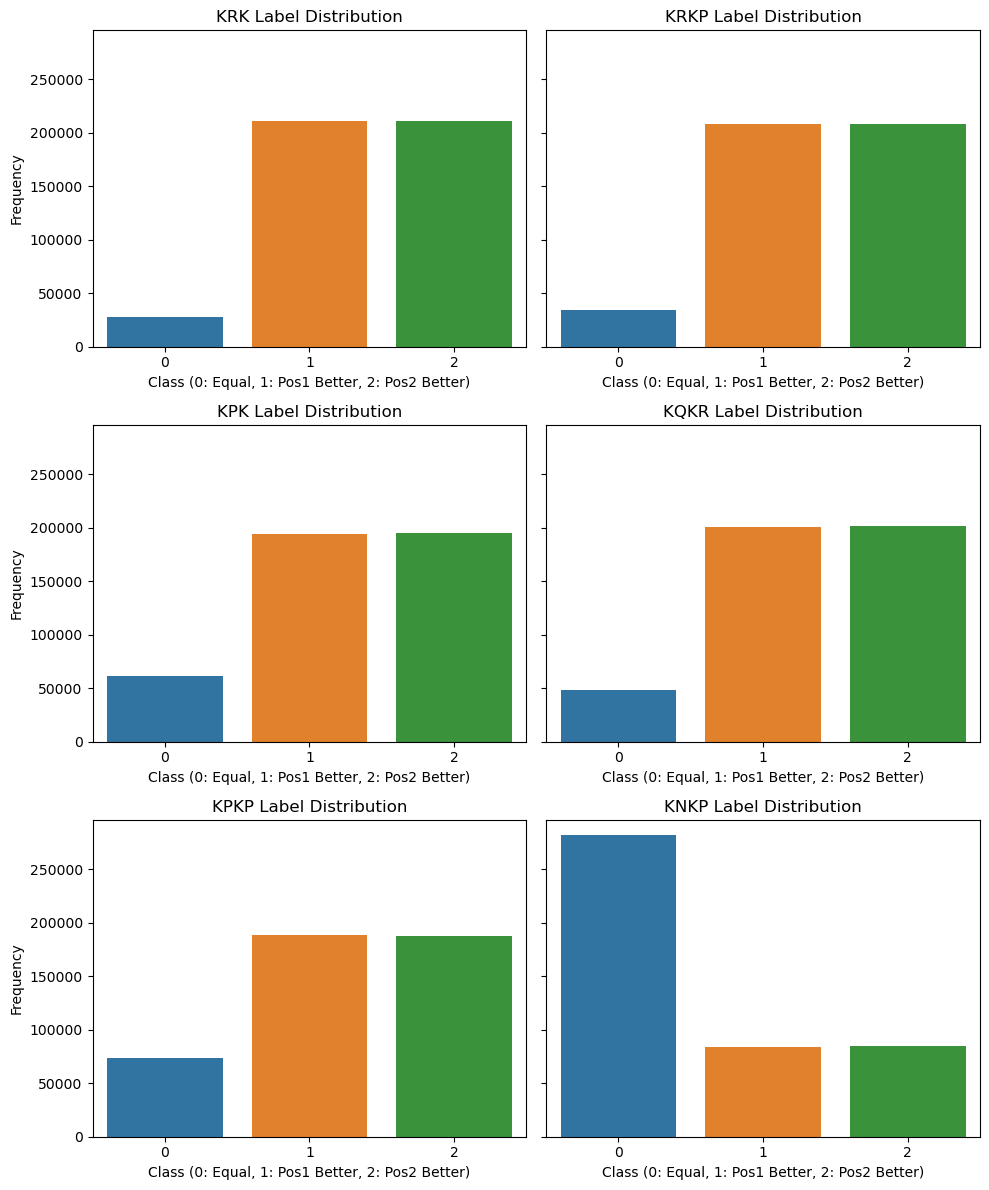

In [7]:
# Define endgames
endgames = {
    "KRK": [chess.ROOK],
    "KRKP": [chess.PAWN, chess.ROOK],
    "KPK": [chess.PAWN],
    "KQKR": [chess.QUEEN, chess.ROOK],
    "KPKP": [chess.PAWN, chess.PAWN],
    "KNKP": [chess.KNIGHT, chess.PAWN]
}

results = {}
for name, additional_pieces in endgames.items():
    labels_train_val, labels_test, counts = process_endgame(name, additional_pieces)
    results[name] = (np.unique(labels_train_val, return_counts=True)[0], np.unique(labels_train_val, return_counts=True)[1])

plot_label_distributions(results)